Imports

In [1]:
import sys
sys.path.append("/home/sanketh/DANI/GraphMatching/")
import torch.multiprocessing as mp
mp.set_start_method("spawn")

In [2]:
import pathlib
import os
import numpy as np
import torch
from torch import optim
from subgraph_matching_via_nn.data.data_loaders import load_graph
from powerful_gnns.util import S2VGraph
from powerful_gnns.util import load_data_given_graph_list_and_label_map
from powerful_gnns.models.graphcnn import GraphCNN
from powerful_gnns.util import separate_data
from powerful_gnns.classifier_training import train, test
from common.EmbeddingCalculationsService import pairwise_l2_distance, show_distance_matrix, \
    calculate_energy_based_hidden_rep
from subgraph_matching_via_nn.training.PairSampleInfo import Pair_Sample_Info
from subgraph_matching_via_nn.data.annotated_graph import AnnotatedGraph
from subgraph_matching_via_nn.graph_metric_networks.graph_metric_nn import MLPGraphMetricNetwork
from subgraph_matching_via_nn.graph_metric_networks.embedding_metric_nn import EmbeddingMetricNetwork
from subgraph_matching_via_nn.graph_embedding_networks.gnn_embedding_network import GNNEmbeddingNetwork
from subgraph_matching_via_nn.training.trainer.S2VGraphEmbeddingSimilarityMetricTrainer import \
    S2VGraphEmbeddingSimilarityMetricTrainer
from subgraph_matching_via_nn.graph_metric_networks.graph_metric_nn import SingleEmbeddingGraphMetricNetwork
from subgraph_matching_via_nn.graph_metric_networks.graph_metric_nn import S2VGraphEmbeddingGraphMetricNetwork
from networkx import NetworkXError
import itertools
import networkx as nx
from common.parallel_computation import tqdm_joblib
import random
from tqdm import tqdm
from joblib import Parallel, delayed
from os import cpu_count
import pickle
from common.graph_utils import GED_graph_generator
from subgraph_matching_via_nn.training.MarginLoss import MarginLoss
import wwl
from wwl import laplacian_kernel
import networkx as nx
from igraph import Graph
from scipy.stats import norm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

In [3]:
def get_graph_wl_distances(graphs, node_label):
    igraphs = [Graph() for i in range(len(graphs))]
    igraphs = [igraph.from_networkx(graph) for igraph, graph in zip(igraphs, graphs)]
    kernel_values = wwl.pairwise_wasserstein_distance(igraphs, [len(igraphs)-1], enforce_continuous=True, num_iterations=10)
    kernel_values = laplacian_kernel(kernel_values) #normalize energey

    # gk_wl = WL_metric.GK_WL()
    # kernel_values = gk_wl.compare_list(graphs, h=5, node_label=node_label)
    return 1- kernel_values
    #return np.round(1 - kernel_values, decimals=4)

In [4]:
def transform_into_s2vgraphs(graphs, labels):
    g_list = []
    label_dict = {}
    for subgraph, label in zip(graphs, labels):
        if type(subgraph) is nx.Graph:
            s2v_graph = S2VGraph(subgraph, label)
        else:
            s2v_graph = S2VGraph(subgraph.G, label)
        g_list.append(s2v_graph)
        if not label in label_dict:
            mapped = len(label_dict)
            label_dict[label] = mapped

    # Process graph features
    graphs, num_classes = load_data_given_graph_list_and_label_map(g_list, label_dict, degree_as_tag=True, device=device)

    return graphs, num_classes

def generate_s2v_graphs(networkx_graphs, print_stats=True):
    graphs, _ = transform_into_s2vgraphs(networkx_graphs, [None for graph in networkx_graphs])

    for s2v_graph in graphs:
        # convert graph features here, not only in trainer! (heatmap is probably wrong)
        annotated_graph = AnnotatedGraph(s2v_graph.g)
        s2v_graph.node_features = annotated_graph.node_indicator.to(device=device)

    return graphs

In [5]:
def plot_map(map, xlabel, ylabel, title):
    keys = list(map.keys())
    values = list(map.values())
      
    fig = plt.figure(figsize = (15, 5))

    # creating the bar plot
    plt.plot(keys, values, color ='maroon')

    extraticks = keys
    xticks = list(extraticks)
    plt.xticks(xticks)

    plt.xlabel(xlabel)
    ax = matplotlib.pyplot.gca()
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def chart_bar_plot(data_map, xlabel, ylabel, title):
    keys = list(data_map.keys())
    values = list(data_map.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(keys, values, color ='maroon',
            width = 0.4)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def plot_histogram(sequence, x_title="", min_range=None, max_range=None):
    # Fit a distribution to the data
    if min_range is None:
        min_range = min(sequence)
    if max_range is None:
        max_range = max(sequence)

    print(min_range)
    print(max_range)
    sequence = [item for item in sequence if ((item >= min_range) and (item <= max_range))]

    fig, ax = plt.subplots(1)
    # sns.histplot(sequence, bins='auto', stat='density',
    #              label='Normalized Histogram', ax=ax)

    mu, std = norm.fit(sequence)
    x = np.linspace(min_range, max_range, 100)
    if not np.all(x == x[0]):
        y = norm.pdf(x, mu, std)
    else:
        y = np.ones_like(x)
    sns.lineplot(x=x, y=y, color='red', label='Fitted Normal Distribution', ax=ax)

    # Plot the KDE
    sns.kdeplot(sequence, label='KDE', bw_adjust=0.5, ax=ax)

    ax.set_xlabel(x_title)
    ax.set_ylabel('Density')
    ax.set_title(f'{x_title} Distribution')
    ax.legend(loc='upper left')
    ax.grid(True)
    plt.show()

In [6]:
# go over pairs in ged_examples1/2, and for their subgraphs generate wl+dist
# only take into account their wl_dist from the all pairs vs all pairs matrix
def generate_wl_dist_for_ged_pairs(ged_examples_list):
    pairs_index_to_dist_map = {}

    all_ged_example_list_graphs = []
    for ged_example_list in ged_examples_list:
        ged_example_list_graphs = [ged_example_list[0].subgraph.g] + [pair.masked_graph.g for pair in ged_example_list]
        all_ged_example_list_graphs += ged_example_list_graphs

    wl_dist_matrix = get_graph_wl_distances(all_ged_example_list_graphs, node_label=False)

    base_graph_index = 0
    pairs_index = 0
    for ged_example_list_index, ged_example_list in enumerate(ged_examples_list):
        for relative_index, pair in enumerate(ged_example_list):
            wl_dist = wl_dist_matrix[base_graph_index][base_graph_index + relative_index + 1]
            pairs_index_to_dist_map[pairs_index] = wl_dist

            pairs_index += 1
        base_graph_index += 1 + (relative_index + 1)

    return pairs_index_to_dist_map

def show_wl_dist_histograms(positive_examples, negative_examples, max_examples_amount = 1000):
    positive_examples_pairs_index_to_dist_map = {}
    negative_examples_pairs_index_to_dist_map = {}

    ged_examples_pairs_index_to_dist_map = generate_wl_dist_for_ged_pairs(positive_examples[:max_examples_amount] + negative_examples[:max_examples_amount])
    print("finished distances calculation")

    for pair_index, wl_dist in ged_examples_pairs_index_to_dist_map.items():
        if pair_index < len(ged_1_examples):
            positive_examples_pairs_index_to_dist_map[pair_index] = wl_dist
        else:
            negative_examples_pairs_index_to_dist_map[pair_index] = wl_dist
    print("plotting")

    plot_histogram(list(positive_examples_pairs_index_to_dist_map.values()), "positive examples WL distance")
    plot_histogram(list(negative_examples_pairs_index_to_dist_map.values()), "negative examples WL distance")

    print(max(positive_examples_pairs_index_to_dist_map.values()))
    print(min(negative_examples_pairs_index_to_dist_map.values()))

    return positive_examples_pairs_index_to_dist_map, negative_examples_pairs_index_to_dist_map

def get_min_non_diagonal_entry(tensor_, single_reference_graph_index=None, show_min_off_diagonal=True):
    # show_min_off_diagonal: True for min, False for max
    shape = tensor_.shape
    assert len(shape) == 2

    is_1_vs_all = False

    if shape[0] != shape[1]:
        assert ((shape[1] == 1) and (single_reference_graph_index is not None))
        is_1_vs_all = True

    diagonal_stub_value = float("inf")
    if not show_min_off_diagonal:
        diagonal_stub_value = -diagonal_stub_value

    if is_1_vs_all:
        tensor_with_inf_diag = tensor_.detach().clone().requires_grad_(False)
        tensor_with_inf_diag[single_reference_graph_index] = diagonal_stub_value
    else:
        tensor_with_inf_diag = tensor_ + torch.diag_embed(torch.ones(tensor_.shape[0], device=device) * diagonal_stub_value)

    if show_min_off_diagonal:
        return torch.min(tensor_with_inf_diag).item()
    else:
        return torch.max(tensor_with_inf_diag).item()

def show_distances_heatmap(graphs, model, show_min_off_diagonal: bool = True):
    # show_min_off_diagonal: True for min, False for max

    model.eval()
    all_embeddings = model.get_embedding(graphs)

    l2_dists = pairwise_l2_distance(all_embeddings)

    rounding_constant = 10 ** 3
    cos_dists = torch.round(calculate_energy_based_hidden_rep(all_embeddings, threshold=-1) * rounding_constant) / rounding_constant

    show_distance_matrix(l2_dists, "l2-distances")
    show_distance_matrix(cos_dists, "cosine-distances")

    print(f"Off matrix diagonal margin: {get_min_non_diagonal_entry(l2_dists, show_min_off_diagonal=show_min_off_diagonal)}")
    print(f"Off matrix diagonal margin: {get_min_non_diagonal_entry(cos_dists, show_min_off_diagonal=show_min_off_diagonal)}")

In [7]:
def get_examples_distances(trainer, graph_metric_nn, samples):

    train_loaders, val_loaders = trainer.get_data_loaders(samples, [], new_samples_amount=0, device_ids=[0])

    positive_distances = []
    negative_distances = []

    # max_pair_batches_to_test = 10

    i = 0

    for pairs_batch in train_loaders[0]:
        # if i >= max_pair_batches_to_test:
        #     break
        i += 1

        with torch.no_grad():
            distances = graph_metric_nn.forward(
                [sample.s2v_graphs for sample in pairs_batch]
            )

        for pair, distance in zip(pairs_batch, distances):
            distance = distance.item()
            is_negative_example = pair.pair_sample_info.is_negative_sample
            # print(f"{i} : {distance}")

            if is_negative_example==False:
                positive_distances.append(distance)
                # if distance > solver_params['margin_loss_margin_value']:
                #     print(f"positive loss term not zero, as distance for this positive example pair is {distance}")
            else:
                negative_distances.append(distance)
                # if distance < solver_params['margin_loss_margin_value']:
                #     print(f"negative loss term not zero, as distance for this negative example pair is {distance}")
    return positive_distances, negative_distances

def calc_margin_loss(distances, pos_labels, margin):
    negative_labels = 1 - pos_labels
    lossCriterion = MarginLoss(margin)
    pos_loss, neg_loss = lossCriterion.get_loss(distances, pos_labels, negative_labels)
    print(pos_loss.sum().item())
    print(neg_loss.sum().item())

In [ ]:
def generate_perturbed_graphs(reference_graph: nx.Graph):
    # assumption: there are no self loops, and no duplicate edges of opposite directions

    # graphs generated by removing an existing edge
    for edge in reference_graph.edges:
        copy_graph = reference_graph.copy()
        copy_graph.remove_edge(*edge)
        yield copy_graph

    # graphs generated by adding a missing edge
    sorted_nodes = sorted(reference_graph.nodes, reverse=False)
    for i, node_i in enumerate(sorted_nodes):
        if i == len(sorted_nodes) - 1:
            break

        for node_j in sorted_nodes[i+1:]:
            edge = (node_i, node_j)
            if reference_graph.has_edge(*edge):
                continue
            copy_graph = reference_graph.copy()
            copy_graph.add_edge(*edge)
            yield copy_graph

def generate_pair_example(G1_annotated, G2_annotated, is_negative_example):
    return Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example))

def compare_graphs_and_generate_pair_example(G1_annotated, G2_annotated):
    SG1 = G1_annotated.g
    SG2 = G2_annotated.g

    if nx.is_isomorphic(SG1, SG2):
        isomorphic_pairs.append((SG1, SG2))
        return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = False)
    else:
        return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = True)

    # try:
    #     diff_graph = nx.symmetric_difference(SG1, SG2)
    # except NetworkXError:
    #     # node sets are different
    #     if nx.is_empty(SG1) and nx.is_empty(SG2) and (len(SG1) == len(SG2)):
    #         # positive example
    #         print("node sets are different, but isomorphic graphs")
    #         return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = False)
    #     else:
    #         # negative example
    #         print("node sets are different, and not isomorphic graphs")
    #         return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = True)

    # if nx.is_empty(diff_graph):
    #     # print("isomorphic graphs")
    #     isomorphic_pairs.append((SG1, SG2))
    #     # positive example
    #     return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = False)
    # else:
    #     # negative example
    #     return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = True)

def generate_random_ged_paris(annotated_subgraph: AnnotatedGraph, ged_dist: int, pairs_n: int, is_negative_example: bool):
    train_samples_list = []
    SG1 = annotated_subgraph

    ged_graph_generator = GED_graph_generator(SG1.g, ged_dist)

    # generate pairs

    for i, ged_perturbed_graph in enumerate(ged_graph_generator.generate()):
        if i == pairs_n:
            break

        # positive example
        train_samples_list.append(generate_pair_example(SG1, AnnotatedGraph(ged_perturbed_graph), is_negative_example = is_negative_example))

    sys.stdout.flush()
    return train_samples_list

In [ ]:
def calc_performance_metrics(graph_metric_nn, samples, positive_distances, negative_distances):
    FP = 0
    FN = 0

    single_pair_forward_positive_distances = []
    single_pair_forward_negative_distances = []
    for i in range(0, len(samples)):
        if i % 5_000 == 0:
            print(f"post iteration {i}")
        is_negative_sample = samples[i].is_negative_sample
        graph1 = samples[i].subgraph
        graph2 = samples[i].masked_graph

        s2v_graphs = generate_s2v_graphs([graph1.g, graph2.g], print_stats=False)

        distance = graph_metric_nn.forward([(s2v_graphs[0], s2v_graphs[1])]).item()

        if is_negative_sample:
            single_pair_forward_negative_distances.append(distance)
            if (distance < solver_params['margin_loss_margin_value']):
                FP += 1
                #print(f"negative loss term not zero, as distance for this negative example pair is {distance}")
        if (not is_negative_sample):
            single_pair_forward_positive_distances.append(distance)
            if (distance > solver_params['margin_loss_margin_value']):
                FN += 1
                #print(f"negative loss term not zero, as distance for this positive example pair is {distance}")
    print(f"FP={FP} out of {len(negative_distances)} negative examples")
    print(f"FN={FN} out of {len(positive_distances)} positive examples")

    return single_pair_forward_positive_distances, single_pair_forward_negative_distances

In [ ]:
def train_model_with_hyperparams(used_train_samples_list, num_layers=5, num_mlp_layers=2, hidden_dim=128, trainer=None):

    last_checkpoint_model_path = None

    # val_samples_list = used_train_samples_list
    model_factory_func = lambda device: GraphCNN(num_layers=num_layers, num_mlp_layers = num_mlp_layers, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
    solver_params["batch_size"] = 512 * 8
    solver_params["k_update_plot"] = 10
    solver_params["lr"] = 1e-1
    solver_params["max_epochs"] = 200
    current_trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, last_checkpoint_model_path)

    if trainer is None:
        best_val_loss = current_trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=False, train_samples_list=used_train_samples_list, val_samples_list=[])
    else:
        current_trainer.set_existing_data_loader_paths(trainer.previous_train_loader_paths, trainer.previous_val_loader_paths)
        best_val_loss = current_trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=True)

    return current_trainer, graph_metric_nn, best_val_loss

In [8]:
goal_subcircuit_name = 'alu'
DATA_PATH = 'C:/Users/kogan/OneDrive/Desktop/Research/AMIT/GraphMatching/subgraph_matching_via_nn/data/subcircuits/'
DATA_PATH = '../subgraph_matching_via_nn/data/subcircuits/'

desktop = pathlib.Path(DATA_PATH)
subgraphs = []
labels = []
for circuit_dir in desktop.iterdir():
    if circuit_dir.is_dir():
        for subcircuit_file in circuit_dir.iterdir():
            if subcircuit_file.is_file():
                file_name = subcircuit_file.name
                if file_name == 'full_graph.p':
                    file_rel_path = f"{os.sep}{file_name}"
                    loader_params = {
                     'data_path' : str(circuit_dir),
                     'g_full_path': file_rel_path,
                     'g_sub_path': file_rel_path}

                    sub_graph = \
                        load_graph(type='subcircuit',
                                   loader_params=loader_params)

                    if goal_subcircuit_name in circuit_dir.name:
                        labels.append(1)
                    else:
                        # continue #TODO?
                        labels.append(0)
                    subgraphs.append(sub_graph)

labels = np.array(labels, dtype='float32')
N = len(subgraphs)
N_training = int(2 / 3 * N)

In [9]:
subgraphs = []
labels = []

subgraphs_for_classification = []

circuit_base_dir = 'C:\\Users\\kogan\\OneDrive\\Desktop\\Research\\AMIT\\GraphMatching\\subgraph_matching_via_nn\\data\\subcircuits\\'
# circuit_base_dir = '/home/sanketh/DANI/GraphMatching/subgraph_matching_via_nn/data/subcircuits/'
CIRCUIT_DUPLICATES_AMOUNT = 5
REFERENCE_GRAPH_ORIGINAL_LABEL = 1
REFERENCE_GRAPH_ORIGINAL_INDEX = 0

for circuit_file_name in ['adder_4', 'alu_4', 'alu_8', 'alu_16', 'alu_32', 'mul_4_4', 'mul_4_8', 'mul_8_8', 'mul_16_16', 'mul_16_32']:
    file_rel_path = 'full_graph.p'
    circuit_dir = f"{circuit_base_dir}{circuit_file_name}{os.sep}"
    loader_params = {
     'data_path' : str(circuit_dir),
     'g_full_path': file_rel_path,
     'g_sub_path': file_rel_path}

    sub_graph = \
        load_graph(type='subcircuit',
                   loader_params=loader_params)
    subgraphs.append(sub_graph)
    for i in range(CIRCUIT_DUPLICATES_AMOUNT):
        subgraphs_for_classification.append(sub_graph)
        labels.append(0)
for i in range(CIRCUIT_DUPLICATES_AMOUNT):
    labels[REFERENCE_GRAPH_ORIGINAL_INDEX * CIRCUIT_DUPLICATES_AMOUNT + i] = REFERENCE_GRAPH_ORIGINAL_LABEL

zipped_graphs_and_labels = list(zip(subgraphs_for_classification, labels))
random.shuffle(zipped_graphs_and_labels)
unzipped_graphs_and_labels = list(zip(*zipped_graphs_and_labels))
subgraphs_for_classification = unzipped_graphs_and_labels[0]
labels = unzipped_graphs_and_labels[1]

N = len(subgraphs_for_classification)
N_training = int(2 / 3 * N)

Transform graphs into S2VGraph-s

In [10]:
device = 'cpu' if torch.cuda.is_available() else 'cpu'

In [11]:
graphs, num_classes = transform_into_s2vgraphs(subgraphs_for_classification, labels)

# classes: 2
# maximum node tag: 48
# data: 50


Setup model and training

In [12]:
#set up seeds and gpu device
torch.manual_seed(0)
np.random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

##k-fold cross validation. Conduct an experiment on the fold specified by args.fold_idx.
# train_graphs, test_graphs = separate_data(graphs, seed=0, fold_idx=0, n_splits=1)
# train_graphs = graphs[:4]
# test_graphs = graphs[4:]
train_graphs = graphs[:N_training]
test_graphs = graphs[N_training:]

model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=train_graphs[0].node_features.shape[1], hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

Train and Test

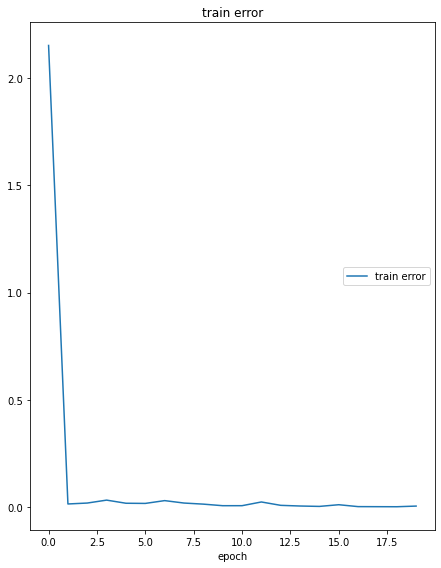

train error
	train error      	 (min:    0.001, max:    2.153, cur:    0.004)


In [13]:
liveloss = PlotLosses(mode='notebook')

filename = ""
epochs = 20
k_update_plot = 1

for epoch in range(1, epochs + 1):
    scheduler.step()

    avg_loss = train(iters_per_epoch=50, batch_size=len(train_graphs), model=model, device=device, train_graphs=train_graphs, optimizer=optimizer, epoch=epoch)
    acc_train, acc_test = test(model, device, train_graphs, test_graphs, epoch)

    if not filename == "":
        with open(filename, 'w') as f:
            f.write("%f %f %f" % (avg_loss, acc_train, acc_test))
            f.write("\n")
    print("")

    print(model.eps)

    if epoch % k_update_plot == 0:
        liveloss.update({'train error': avg_loss.item()})
        liveloss.send()

In [14]:
acc_train

1.0

In [15]:
acc_test

1.0

Show predictions

In [16]:
model.eval()
pred = model(train_graphs).max(1, keepdim=True)[1]
print(pred)

tensor([[0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


In [17]:
pred = model(test_graphs).max(1, keepdim=True)[1]
print(pred)

tensor([[0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0]])


show all distances matrix (margin)

In [18]:
# keep only one instance of each graph
graphs, num_classes = transform_into_s2vgraphs(subgraphs, labels)

all_embeddings = model.get_embedding(graphs)

# classes: 2
# maximum node tag: 48
# data: 10


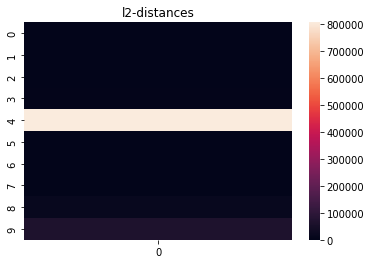

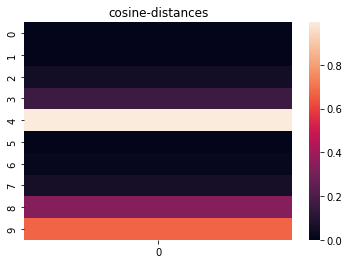

In [19]:
l2_dists = pairwise_l2_distance(all_embeddings)[REFERENCE_GRAPH_ORIGINAL_INDEX].reshape(-1, 1)

rounding_constant = 10 ** 3
cos_dists = (torch.round(calculate_energy_based_hidden_rep(all_embeddings, threshold=-1) * rounding_constant) / rounding_constant)[REFERENCE_GRAPH_ORIGINAL_INDEX].reshape(-1, 1)

show_distance_matrix(l2_dists, "l2-distances")
show_distance_matrix(cos_dists, "cosine-distances")

what is the smallest margin?

In [20]:
print(get_min_non_diagonal_entry(l2_dists, REFERENCE_GRAPH_ORIGINAL_INDEX))
print(get_min_non_diagonal_entry(cos_dists, REFERENCE_GRAPH_ORIGINAL_INDEX))

17.636625289916992
0.003000000026077032


Contrastive loss training

Assemble graph pairs data

In [21]:
train_samples_list = []
reference_subgraph = subgraphs[REFERENCE_GRAPH_ORIGINAL_INDEX]
negative_examples_subgraphs = subgraphs[:REFERENCE_GRAPH_ORIGINAL_INDEX] + subgraphs[REFERENCE_GRAPH_ORIGINAL_INDEX+1:]

for subgraph in subgraphs:
    if subgraph == reference_subgraph:
        is_negative_example = False
    else:
        is_negative_example = True

    G1_annotated = AnnotatedGraph(subgraph.G)
    G2_annotated = AnnotatedGraph(reference_subgraph.G)
    train_samples_list.append(Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example)))

val_samples_list = train_samples_list

Define GNN model

In [22]:
# input dim matches the node mask (w) shape
input_dim = S2VGraphEmbeddingSimilarityMetricTrainer.get_model_expected_input_dim(train_samples_list[0])
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)

Define graph metric to train, and the trainer

In [23]:
solver_params = {
    "device": device,
    "lr": 1e-3, "weight_decay": 1e-3,
    "max_epochs": 50,
    "cycle_patience": 5, "step_size_up": 10, "step_size_down": 10,
    "loss_convergence_threshold": None,
    "train_loss_convergence_threshold": 1e-3,
    "successive_convergence_min_iterations_amount": 5,
    "margin_loss_margin_value": 5,
    "max_grad_norm": 0.1,
    "k_update_plot": 1,
    "train_monitoring_epochs_pace": 5,
    "batch_size": len(subgraphs),
    "num_workers": 0,
    "is_use_model_compliation": False, #Only supported for Pytorch > 2.0
    "model_checkpoint_epochs_pace": 10,
}

problem_params = {"input_dim": input_dim}

dump_base_path = f".{os.sep}runlogs"

def create_graph_metric_net(model_factory_func, device):
    model = model_factory_func(device=device)

    loss_fun = torch.nn.MSELoss()
    embedding_metric_network = EmbeddingMetricNetwork(loss_fun=loss_fun)

    gnn_embedding_nn = GNNEmbeddingNetwork(gnn_model=model)

    # embedding_nns = \
    #     [
    #         GNNEmbeddingNetwork(gnn_model=model),
    #     ]

    graph_metric_nn = S2VGraphEmbeddingGraphMetricNetwork(embedding_network=gnn_embedding_nn,
                                           embdding_metric_network=embedding_metric_network,
                                           device=device)

    # graph_metric_nn = SingleEmbeddingGraphMetricNetwork(embedding_network=embedding_nns[0],
    #                                        embdding_metric_network=embedding_metric_network,
    #                                        device=device)

    # graph_metric_nn = MLPGraphMetricNetwork(embedding_networks=embedding_nns,
    #                                         embdding_metric_network=embedding_metric_network,
    #                                         device=device)

    return graph_metric_nn, model

def init_embedding_net_and_trainer(model_factory_func, graph_metric_nn_checkpoint_path=None):

    # must start on CPU to allow moving model to GPU, due to existing pytorch bug
    device = 'cpu'
    graph_metric_nn, model = create_graph_metric_net(model_factory_func, device)

    if graph_metric_nn_checkpoint_path is not None:
        graph_metric_nn.load_state_dict(torch.load(graph_metric_nn_checkpoint_path, map_location=device))
        model = graph_metric_nn.embedding_networks[0].gnn_model

    if solver_params['is_use_model_compliation']:
        graph_metric_nn = torch.compile(graph_metric_nn)
        model = graph_metric_nn.embedding_networks[0].gnn_model

    trainer = S2VGraphEmbeddingSimilarityMetricTrainer(graph_metric_nn, dump_base_path,
                                      problem_params, solver_params)

    return trainer, graph_metric_nn, model

trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func)

Train

# classes: 1
# maximum node tag: 48
# data: 10


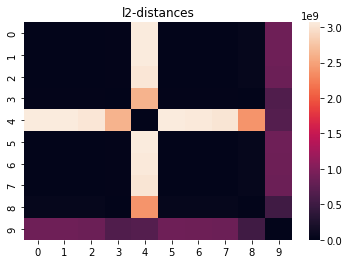

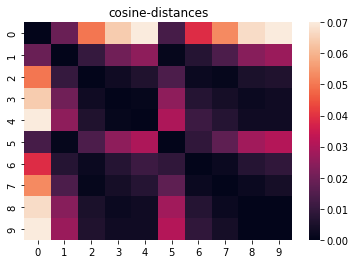

Off matrix diagonal margin: 73.08867645263672
Off matrix diagonal margin: 0.0


In [24]:
show_distances_heatmap(generate_s2v_graphs([graph.g for graph in graphs]), model)

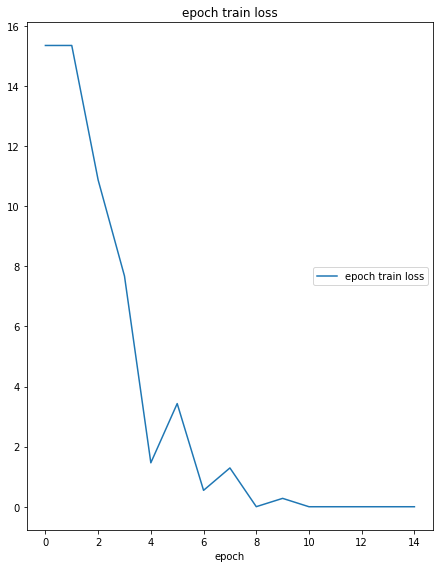

epoch train loss
	epoch train loss 	 (min:    0.000, max:   15.350, cur:    0.000)
finished monitoring training


9.999999717180685e-10

In [25]:
trainer.train(processes_device_ids=['cpu'], use_existing_data_loaders=False, train_samples_list=train_samples_list, val_samples_list=val_samples_list)

# classes: 1
# maximum node tag: 48
# data: 10


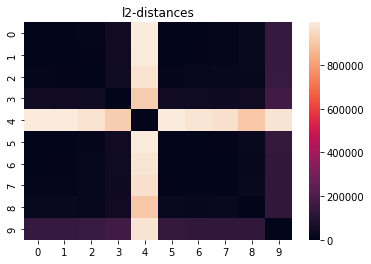

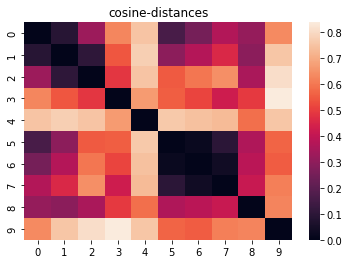

Off matrix diagonal margin: 476.2375183105469
Off matrix diagonal margin: 0.019999999552965164


In [26]:
show_distances_heatmap(generate_s2v_graphs([graph.g for graph in graphs]), model)

Add ged=1 examples as positive examples

In [27]:
# generate subgraphs for which ged(subgraph, reference_subgraph)==1
perturbed_graphs = list(generate_perturbed_graphs(reference_subgraph.G_sub))
for perturbed_graph in perturbed_graphs:
    is_negative_example = False

    G1_annotated = AnnotatedGraph(perturbed_graph)
    G2_annotated = AnnotatedGraph(reference_subgraph.G)
    train_samples_list.append(Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example)))

In [28]:
len(train_samples_list)

101

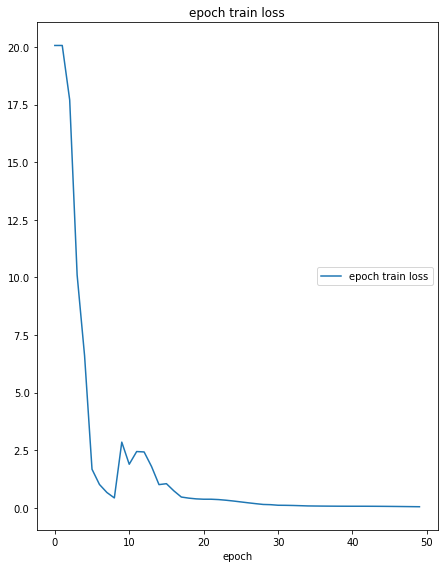

epoch train loss
	epoch train loss 	 (min:    0.050, max:   20.065, cur:    0.050)
Monitoring process is exiting, epochs=50
finished monitoring training


0.0472794733941555

In [29]:
val_samples_list = train_samples_list
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = len(train_samples_list)

trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func)

trainer.train(processes_device_ids=['cpu'], use_existing_data_loaders=False, train_samples_list=train_samples_list, val_samples_list=val_samples_list)

In [30]:
all_s2v_graphs = generate_s2v_graphs([subgraph.G for subgraph in subgraphs] + perturbed_graphs)
# show_distances_heatmap(all_s2v_graphs, model)

# classes: 1
# maximum node tag: 49
# data: 101


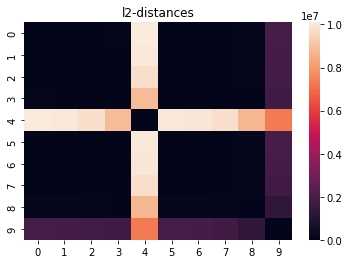

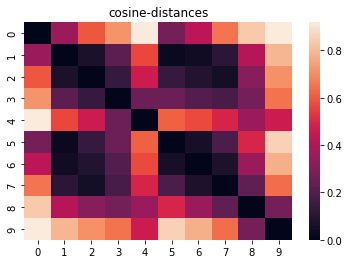

Off matrix diagonal margin: 38.4167366027832
Off matrix diagonal margin: 0.024000000208616257


In [31]:
show_distances_heatmap(all_s2v_graphs[:len(subgraphs)], model)

In [32]:
reference_s2v_graph = all_s2v_graphs[REFERENCE_GRAPH_ORIGINAL_INDEX]
reference_graph_with_positive_examples = [reference_s2v_graph] + all_s2v_graphs[len(subgraphs):]
reference_graph_with_negative_examples = [all_s2v_graphs[i] for i in range(len(all_s2v_graphs[:len(subgraphs)]))]

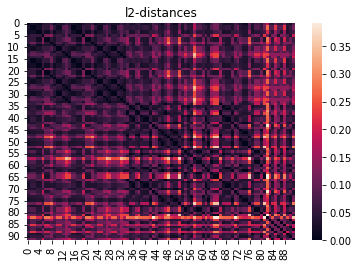

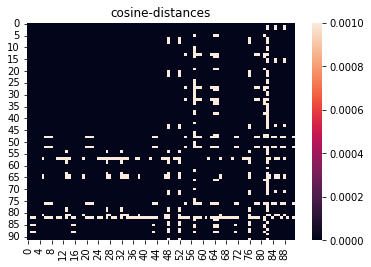

Off matrix diagonal margin: 0.3923964202404022
Off matrix diagonal margin: 0.0010000000474974513


In [33]:
show_distances_heatmap(reference_graph_with_positive_examples, model, show_min_off_diagonal=False)

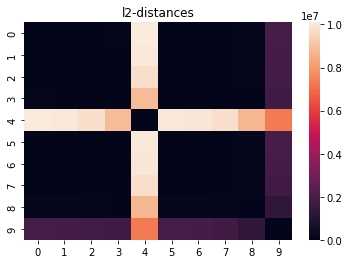

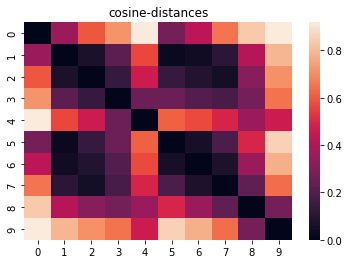

Off matrix diagonal margin: 38.4167366027832
Off matrix diagonal margin: 0.024000000208616257


In [34]:
show_distances_heatmap(reference_graph_with_negative_examples, model, show_min_off_diagonal=True)

In [35]:
_ = graph_metric_nn.eval()

In [36]:
positive_distances = []
for positive_example_second_graph in reference_graph_with_positive_examples:
    distance = graph_metric_nn.forward([(reference_s2v_graph, positive_example_second_graph)]).item()
    positive_distances.append(distance)
    if distance > solver_params['margin_loss_margin_value']:
        print(f"positive loss term not zero, as distance for this positive example pair is {distance}")

negative_distances = []
for negative_example_second_graph in reference_graph_with_negative_examples:
    if negative_example_second_graph == reference_s2v_graph:
        continue #ignore the same graph with itself
    distance = graph_metric_nn.forward([(reference_s2v_graph, negative_example_second_graph)]).item()
    negative_distances.append(distance)
    if distance < solver_params['margin_loss_margin_value']:
        print(f"negative loss term not zero, as distance for this negative example pair is {distance}")

negative loss term not zero, as distance for this negative example pair is 4.612793445587158


In [37]:
max(positive_distances)

0.002778413938358426

In [38]:
min(negative_distances)

4.612793445587158

k-subgraphs experiment

In [39]:
K = 11
full_graph = reference_subgraph.G

subgraphs_iterator = itertools.combinations(full_graph, K)
k_subgraphs = [full_graph.subgraph(s) for s in subgraphs_iterator]
k_subgraph_annotated_graphs = [AnnotatedGraph(g) for g in k_subgraphs]

train_samples_list = []
isomorphic_pairs = []
train_sample_indices_tuple_list = []

In [40]:
for subgraph_counter1, SG_annotated_1 in enumerate(k_subgraph_annotated_graphs):
    for subgraph_counter2 in range(subgraph_counter1+1, len(k_subgraph_annotated_graphs)):
        SG_annotated_2 = k_subgraph_annotated_graphs[subgraph_counter2]
        train_samples_list.append(compare_graphs_and_generate_pair_example(SG_annotated_1, SG_annotated_2))
        train_sample_indices_tuple_list.append((subgraph_counter1, subgraph_counter2))
        # if train_samples_list[-1].is_negative_sample == False:
        #     print(f"{subgraph_counter1} vs {subgraph_counter2}")

In [41]:
used_train_samples_list = train_samples_list[:10_000]

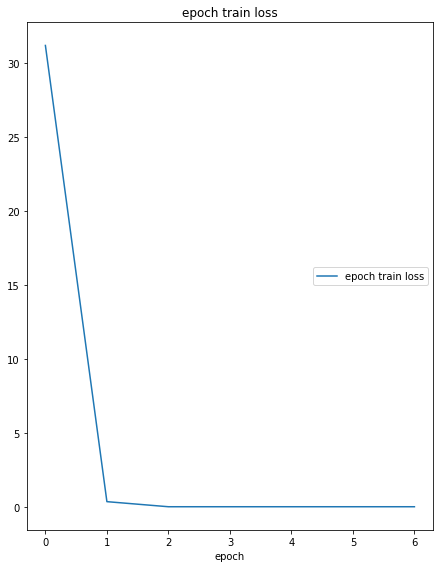

epoch train loss
	epoch train loss 	 (min:    0.000, max:   31.204, cur:    0.000)
training worker process #0 finished
finished monitoring training


8.407375162722275e-08

In [42]:
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=128, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = 512
solver_params["k_update_plot"] = 1
solver_params["lr"] = 1e-1
solver_params["max_epochs"] = 50
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, None)

trainer.train(processes_device_ids=[0], use_existing_data_loaders=False, train_samples_list=used_train_samples_list, val_samples_list=[])

In [43]:
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, "./mp/1704585490.4369323/best_model_state_dict.pt")
_ = graph_metric_nn.eval()

0
20


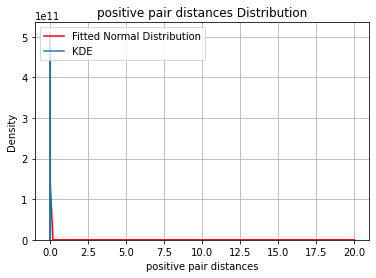

0
20


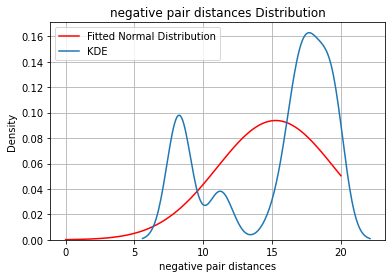

1.1481497697030107e-10
0.0


In [44]:
train_positive_distances, train_negative_distances = get_examples_distances(trainer, graph_metric_nn, used_train_samples_list)
plot_histogram(train_positive_distances, "positive pair distances", min_range=0, max_range=20)
plot_histogram(train_negative_distances, "negative pair distances", min_range=0, max_range=20)
calc_margin_loss(torch.tensor(train_positive_distances+train_negative_distances), torch.cat((torch.ones(len(train_positive_distances)), torch.zeros(len(train_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

In [45]:
# ged_pairs_dump_base_path = f".{os.sep}ged_pairs

# loaded_ged_examples = []
# for i, doc_path in enumerate(pathlib.Path(ged_pairs_dump_base_path).rglob("*.p*")):
#     k_subgraph_ged_pairs_list = pickle.load(open(doc_path, 'rb'))
#     loaded_ged_examples += k_subgraph_ged_pairs_list
#     print(i)

# if not os.path.exists(ged_pairs_dump_base_path):
#     os.makedirs(ged_pairs_dump_base_path)
#
# # k_subgraph_to_perturbed_graphs_map = {}
# def generate_ged_paris(subgraph_counter1):
#     train_samples_list = []
#     SG1 = k_subgraph_annotated_graphs[subgraph_counter1]
#     ged1_perturbed_graphs = list(generate_perturbed_graphs(SG1.g))
#     for ged1_perturbed_graph in ged1_perturbed_graphs:
#         # positive example
#         train_samples_list.append(generate_pair_example(SG1, AnnotatedGraph(ged1_perturbed_graph), is_negative_example = False))
#
#         ged2_perturbed_graphs = list(generate_perturbed_graphs(ged1_perturbed_graph))
#         for ged2_perturbed_graph in ged2_perturbed_graphs:
#             # could be positive or negative example
#             train_samples_list.append(compare_graphs_and_generate_pair_example(k_subgraph_annotated_graphs[subgraph_counter1], AnnotatedGraph(ged2_perturbed_graph)))
#
#     path = os.path.join(ged_pairs_dump_base_path, f"subgraph_{subgraph_counter1}.p")
#     with open(path, 'wb') as f:
#         pickle.dump(train_samples_list, f)
#     return train_samples_list
#
# total_tasks = len(k_subgraphs)
# with tqdm_joblib(tqdm(desc="My calculation", total=total_tasks)) as progress_bar:
#     #Parallel(n_jobs=16)(delayed(long_task)() for i in range(10))
#
#     ged_examples = Parallel(n_jobs=int(cpu_count()), prefer='processes')(
#         delayed(generate_ged_paris)(subgraph_counter1=subgraph_counter1)
#         for subgraph_counter1 in range(total_tasks)
#     )
#
# # generate subgraphs for which GED==1
# for subgraph_counter1, SG1 in enumerate(k_subgraphs):
#     print(subgraph_counter1)
#     ged1_perturbed_graphs = list(generate_perturbed_graphs(SG1))
#     for ged1_perturbed_graph in ged1_perturbed_graphs:
#         # positive example
#         train_samples_list.append(generate_pair_example(SG1, ged1_perturbed_graph, is_negative_example = False))
#         #
#         # ged2_perturbed_graphs = list(generate_perturbed_graphs(ged1_perturbed_graph))
#         # for ged2_perturbed_graph in ged2_perturbed_graphs:
#         #     # could be positive or negative example
#         #     train_samples_list.append(compare_graphs_and_generate_pair_example(k_subgraph_annotated_graphs[subgraph_counter1], AnnotatedGraph(ged2_perturbed_graph)))
#     # k_subgraph_to_perturbed_graphs_map[SG1] = perturbed_graphs

#
#
# # generate all pairs examples
# for SG1, SG1_perturbed_graphs in k_subgraph_to_perturbed_graphs_map.items():
#     for SG2, SG2_perturbed_graphs in k_subgraph_to_perturbed_graphs_map.items():
#
#         if SG1 == SG2:
#             continue # trivial pairs, or pairs already considered
#
#         for SG2_perturbed_graph in SG2_perturbed_graphs:
#             train_samples_list.append(compare_graphs_and_generate_pair_example(SG1, SG2_perturbed_graph))
#
#         for SG1_perturbed_graph in SG1_perturbed_graphs:
#             train_samples_list.append(compare_graphs_and_generate_pair_example(SG1_perturbed_graph, SG2))

In [39]:
random_k_subgraphs = k_subgraph_annotated_graphs.copy()


POSITIVE_EXAMPLES_GED_DIST_pairs_n = -1 #2000
POSITIVE_EXAMPLES_GED_DIST = 1
POSITIVE_EXAMPLES_k_subgraphs = random_k_subgraphs

NEGATIVE_EXAMPLES_GED_DIST_pairs_n = 3000
NEGATIVE_EXAMPLES_GED_DIST = 4 #4
NEGATIVE_EXAMPLES_k_subgraphs = random_k_subgraphs[:20]

with tqdm_joblib(tqdm(desc="My calculation", total=len(NEGATIVE_EXAMPLES_k_subgraphs))) as progress_bar:
    ged_2_examples = Parallel(n_jobs=int(cpu_count()), prefer='processes')(
        delayed(generate_random_ged_paris)(annotated_subgraph=annotated_subgraph, ged_dist=NEGATIVE_EXAMPLES_GED_DIST, pairs_n=NEGATIVE_EXAMPLES_GED_DIST_pairs_n, is_negative_example=True)
        for annotated_subgraph in NEGATIVE_EXAMPLES_k_subgraphs
    )

with tqdm_joblib(tqdm(desc="My calculation", total=len(random_k_subgraphs))) as progress_bar:
    ged_1_examples = Parallel(n_jobs=int(cpu_count()), prefer='processes')(
        delayed(generate_random_ged_paris)(annotated_subgraph=annotated_subgraph, ged_dist=POSITIVE_EXAMPLES_GED_DIST, pairs_n=POSITIVE_EXAMPLES_GED_DIST_pairs_n, is_negative_example=False)
        for annotated_subgraph in POSITIVE_EXAMPLES_k_subgraphs
    )

ged_examples1 = [elem for lst in ged_1_examples for elem in lst]
ged_examples2 = [elem for lst in ged_2_examples for elem in lst]
ged_examples = ged_examples1 + ged_examples2
random.shuffle(ged_examples)

train_ratio = 0.7
train_ged_examples_amount = int(len(ged_examples) * train_ratio)
train_ged_examples = ged_examples[:train_ged_examples_amount]
eval_ged_examples = ged_examples[train_ged_examples_amount:]

My calculation:   1%|▉                                                                                       | 4/364 [00:00<00:44,  8.11it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:   2%|█▍                                                                                      | 6/364 [00:00<00:35, 10.09it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:   5%|████                                                                                   | 17/364 [00:00<00:12, 27.67it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:   8%|██████▉                                                                                | 29/364 [00:01<00:08, 40.13it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  11%|█████████▎                                                                             | 39/364 [00:01<00:08, 38.74it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  12%|██████████▌                                                                            | 44/364 [00:01<00:08, 37.47it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  14%|████████████▍                                                                          | 52/364 [00:01<00:08, 36.65it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  16%|██████████████▎                                                                        | 60/364 [00:02<00:08, 37.03it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  20%|█████████████████▏                                                                     | 72/364 [00:02<00:07, 36.88it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  21%|██████████████████▏                                                                    | 76/364 [00:02<00:07, 37.17it/s]

finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  24%|█████████████████████                                                                  | 88/364 [00:05<00:36,  7.57it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  30%|█████████████████████████▉                                                            | 110/364 [00:05<00:11, 21.34it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  35%|██████████████████████████████▏                                                       | 128/364 [00:05<00:06, 34.04it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  40%|██████████████████████████████████                                                    | 144/364 [00:06<00:04, 45.71it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  44%|█████████████████████████████████████▊                                                | 160/364 [00:06<00:03, 56.73it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  46%|███████████████████████████████████████▋                                              | 168/364 [00:06<00:03, 57.88it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  50%|███████████████████████████████████████████▏                                          | 183/364 [00:06<00:02, 63.62it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  55%|███████████████████████████████████████████████▍                                      | 201/364 [00:06<00:02, 74.27it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  60%|███████████████████████████████████████████████████▌                                  | 218/364 [00:07<00:01, 77.05it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  65%|████████████████████████████████████████████████████████▏                             | 238/364 [00:07<00:01, 84.35it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  70%|████████████████████████████████████████████████████████████▍                         | 256/364 [00:07<00:01, 84.33it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation:  76%|█████████████████████████████████████████████████████████████████▋                    | 278/364 [00:07<00:00, 96.93it/s]

finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation
finished generation


My calculation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:08<00:00, 43.45it/s]


In [40]:
len(train_ged_examples)

56014

In [41]:
len(ged_examples2)

60000

In [42]:
len(ged_examples1)

20020

In [43]:
for k_subgraph in k_subgraphs:
    if k_subgraphs[0].nodes == k_subgraph.nodes:
        print("yes")

yes


In [44]:
len(k_subgraphs)

364

In [46]:
len(train_ged_examples)

56014

check 1-WL distance

In [48]:
# optimized single call for WL distance calculation
### NOTE: Wl dist is not stable (depends which batch of graph you applied it with) ###
# wl_dist_matrix = get_graph_wl_distances(k_subgraphs, node_label=False)

# negative_pairs_wl_distances = []
# positive_pairs_wl_distances = []
#
# positive_pairs_index_to_dist_map = {}
# negative_pairs_index_to_dist_map = {}
#
# for i, train_sample in enumerate(train_samples_list):
#     is_negative_sample = train_sample.is_negative_sample
#     graph1 = train_sample.subgraph
#     graph2 = train_sample.masked_graph
#
#     # s2v_graphs = generate_s2v_graphs([graph1.g, graph2.g], print_stats=False)
#
#     # distance = graph_metric_nn.forward([(s2v_graphs[0], s2v_graphs[1])]).item()
#
#     # wl_dist = get_graph_wl_distances([graph1.g, graph2.g], node_label=False)[0][1]
#
#     graph1_index, graph2_index = train_sample_indices_tuple_list[i]
#     wl_dist = wl_dist_matrix[graph1_index][graph2_index]
#     wl_dist = round(wl_dist, 6)
#
#     if is_negative_sample:
#         negative_pairs_wl_distances.append(wl_dist)
#         negative_pairs_index_to_dist_map[i] = wl_dist
#     else:
#         positive_pairs_wl_distances.append(wl_dist)
#         positive_pairs_index_to_dist_map[i] = wl_dist

In [49]:
# _, _ = show_wl_dist_histograms(ged_1_examples, ged_2_examples, max_examples_amount = 1_000)

In [50]:
# margin = 0.001
# calc_margin_loss(torch.tensor(positive_pairs_wl_distances+negative_pairs_wl_distances), torch.cat((torch.ones(len(positive_pairs_wl_distances)), torch.zeros(len(negative_pairs_wl_distances)))), margin)

Fit GNN on k subgraph GED pairs

In [51]:
# disable debugging overhead operations
torch.autograd.set_detect_anomaly(mode=False)

In [52]:
solver_params['margin_loss_margin_value'] = 0.5 #0.25 #0.01

In [53]:
# used_train_samples_amount = 50_000
used_train_samples_list = train_ged_examples#[:used_train_samples_amount] #Needed due to performance issues
processes_device_ids = [0, 1, 2, 3]

In [54]:
len(used_train_samples_list)

56014

In [55]:
last_checkpoint_model_path = None

# val_samples_list = used_train_samples_list
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=128, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = 512 * 8 #32 #2048 #1024 #512
solver_params["k_update_plot"] = 1
solver_params["lr"] = 1e-1
solver_params["max_epochs"] = 200 #480--
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, last_checkpoint_model_path)

# trainer.set_existing_data_loader_paths(
#     ['./dataloaders/1702148493.0283618.p',
#  './dataloaders/1702148497.9922142.p',
#  './dataloaders/1702148502.9499629.p',
#  './dataloaders/1702148511.1819935.p'],
# []
# )

In [ ]:
trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=False, train_samples_list=used_train_samples_list, val_samples_list=[])

In [ ]:
# GED2 -> "./mp/1703271648.8009052/best_model_state_dict.pt", not seperable well
# GED4 - > ""./mp/1703279923.1549501/best_model_state_dict.pt", seperable well (not perfect but close)

In [ ]:
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, "./mp/1703411975.73806/best_model_state_dict.pt")
_ = graph_metric_nn.eval()

In [ ]:
train_positive_distances, train_negative_distances = get_examples_distances(trainer, graph_metric_nn, used_train_samples_list)

In [ ]:
len(train_negative_distances) / len(train_positive_distances)

In [ ]:
plot_histogram(train_positive_distances, "train positive examples", min_range=0, max_range=0.2)

In [ ]:
plot_histogram(train_negative_distances, "train negative examples", min_range=0, max_range=0.2)

In [ ]:
calc_margin_loss(torch.tensor(train_positive_distances+train_negative_distances), torch.cat((torch.ones(len(train_positive_distances)), torch.zeros(len(train_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

Train again without rebuilding data loaders, and without the val_loader

In [ ]:
# model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
# new_trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func)

# new_trainer.previous_train_loader_paths = trainer.previous_train_loader_paths
# new_trainer.previous_val_loader_paths = [None for device_id in processes_device_ids] #trainer.previous_val_loader_paths
# new_trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=True)

In [ ]:
_, _ = calc_performance_metrics(graph_metric_nn, used_train_samples_list, train_positive_distances, train_negative_distances)

Generalization error

In [ ]:
eval_positive_distances, eval_negative_distances = get_examples_distances(trainer, graph_metric_nn, eval_ged_examples)

In [ ]:
plot_histogram(eval_positive_distances, "eval positive examples", max_range=2)

In [ ]:
plot_histogram(eval_negative_distances, "eval negative examples", max_range=1)

In [ ]:
calc_margin_loss(torch.tensor(eval_positive_distances+eval_negative_distances), torch.cat((torch.ones(len(eval_positive_distances)), torch.zeros(len(eval_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

In [ ]:
_, _ = calc_performance_metrics(graph_metric_nn, eval_ged_examples, eval_positive_distances, eval_negative_distances)

Execution time profiling

In [ ]:
# from cProfile import Profile
# from pstats import SortKey, Stats

# with Profile() as profile:
#     new_trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=True)
#     (
#     Stats(profile)
#         .strip_dirs()
#         .sort_stats(SortKey.CUMULATIVE)
#         .print_stats()
#     )

Capacity test

rank 0 , epochs trained:  200
model saved at ./mp/1703523117.599443/best_model_state_dict.pt
worker process 0 is terminating at 18:51:57


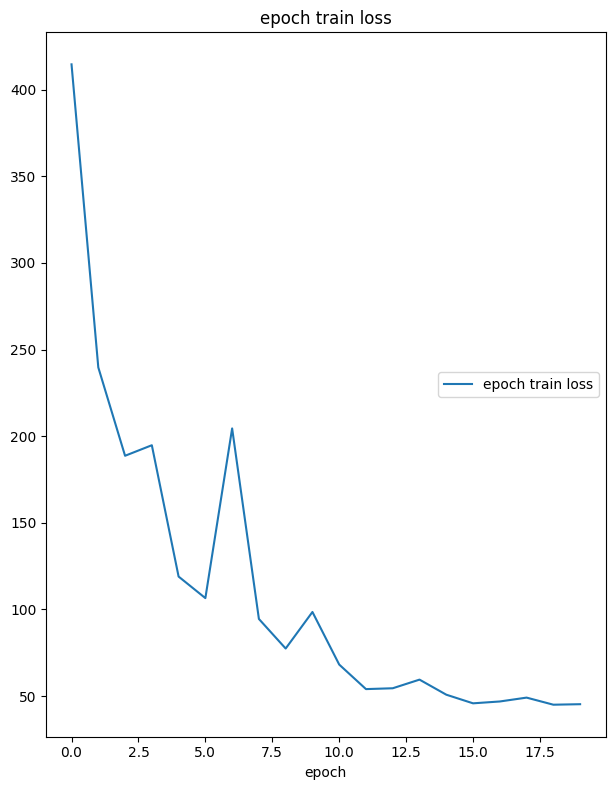

epoch train loss
	epoch train loss 	 (min:   45.003, max:  414.590, cur:   45.294)
Monitoring process is exiting, epochs=200
model saved at ./mp/1703523117.6117768/best_model_state_dict.pt
training worker process #0 finished
training worker process #1 finished
training worker process #2 finished
training worker process #3 finished
finished monitoring training
2048: 40.000513046979904


In [59]:
trainer = None
hid_dim_to_val_loss_map = {}
for hid_dim in [16, 32, 64, 128, 256, 512, 1024, 2048]:
    trainer, graph_metric_nn, best_val_loss = train_model_with_hyperparams(used_train_samples_list, hidden_dim=hid_dim, trainer=trainer)
    hid_dim_to_val_loss_map[hid_dim] = best_val_loss
    print(f"{hid_dim}: {best_val_loss}")

{16: 70.74730545282364, 32: 60.387146949768066, 64: 58.27804559469223, 128: 56.14972960948944, 256: 53.67232429981232, 512: 48.58573704957962, 1024: 46.206315875053406, 2048: 40.000513046979904}


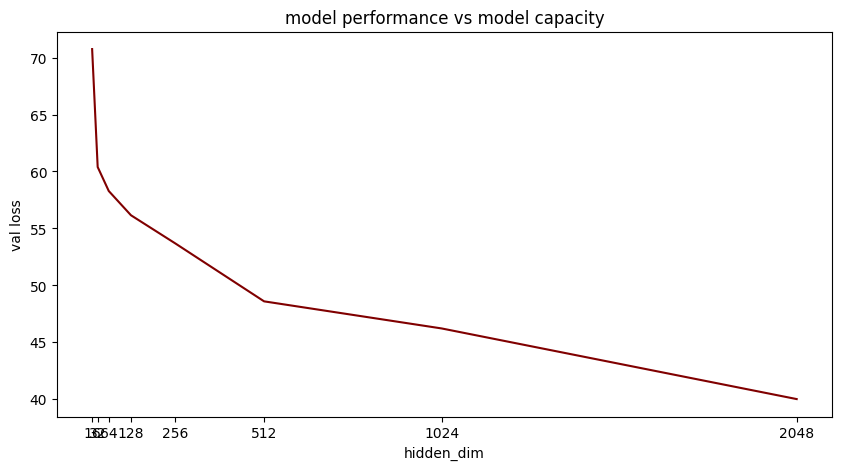

In [75]:
print(hid_dim_to_val_loss_map)
plot_map(hid_dim_to_val_loss_map, "hidden_dim", "val loss", "model performance vs model capacity")

Expressivity test

rank 0 , epochs trained:  200
model saved at ./mp/1703528584.5172565/best_model_state_dict.pt
worker process 0 is terminating at 20:23:04
model saved at ./mp/1703528584.527301/best_model_state_dict.pt


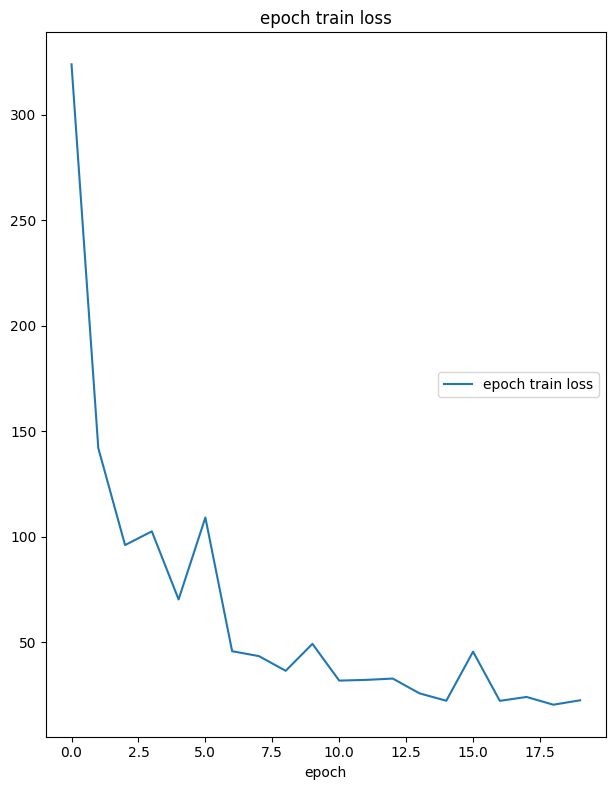

epoch train loss
	epoch train loss 	 (min:   20.458, max:  323.814, cur:   22.542)
Monitoring process is exiting, epochs=200
training worker process #0 finished
training worker process #1 finished
training worker process #2 finished
training worker process #3 finished
finished monitoring training
negative K=8: val_loss=19.260009042918682
post iteration 0
post iteration 5000
post iteration 10000
post iteration 15000
post iteration 20000
post iteration 25000
FP=3173 out of 11213 negative examples
FN=0 out of 14001 positive examples
post iteration 0
post iteration 5000
post iteration 10000
FP=1353 out of 4787 negative examples
FN=0 out of 6019 positive examples
92.48161315917969
23.83431625366211
0
2


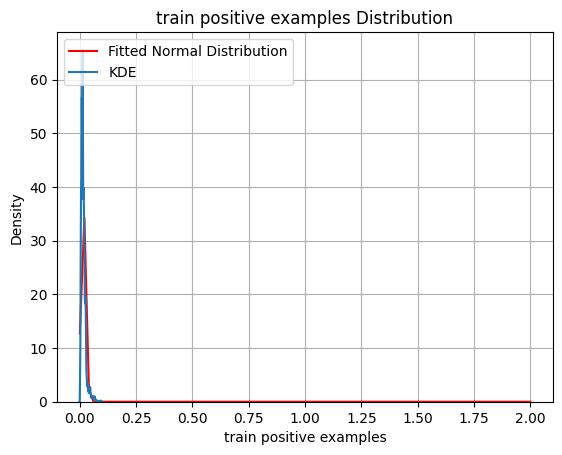

0
2


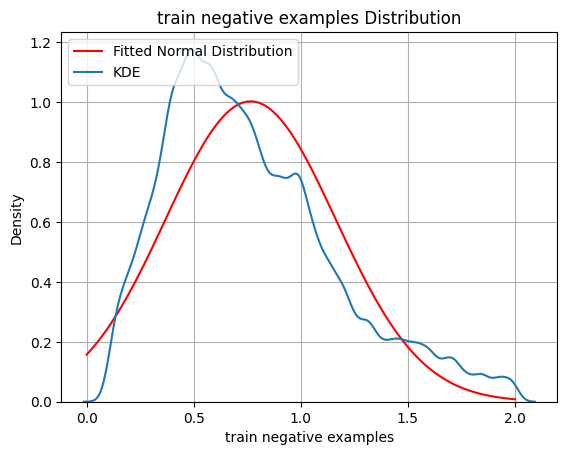

0
2


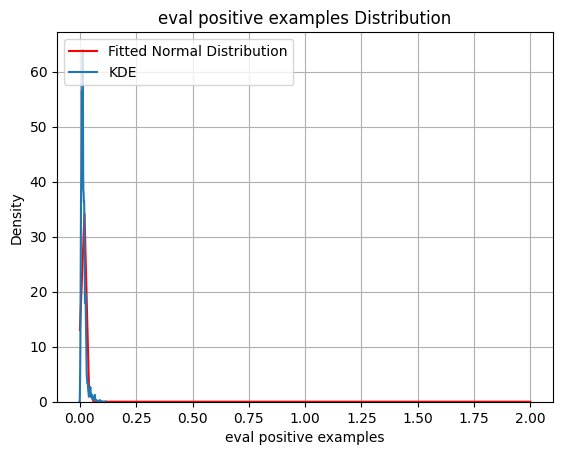

0
2


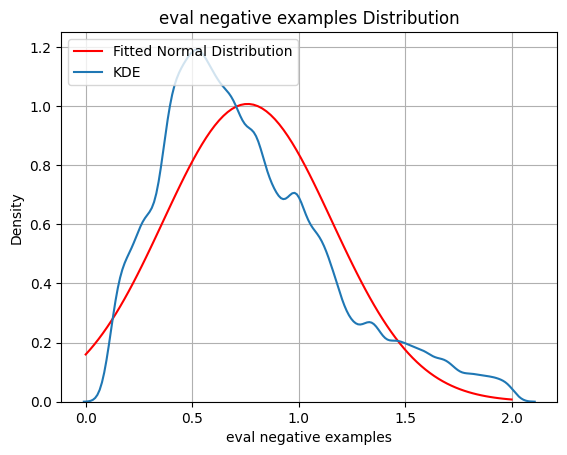

expressivity test for negative_GED_k=9


My calculation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:00<00:00,  9.04s/it]


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [68]:
positive_GED_k_to_negative_GED_k_to_val_loss_map = {}
pairs_n = 800
positive_examples_k_subgraphs = random_k_subgraphs[:20]
ged_positive_examples_cache_map = {}
ged_negative_examples_cache_map = {}

for positive_GED_k in [2, 3, 4, 5, 6, 7]:
    negative_GED_k_to_val_loss_map = {}
    positive_GED_k_to_negative_GED_k_to_val_loss_map[positive_GED_k] = negative_GED_k_to_val_loss_map

    # prepare positive pairs dataset
    with tqdm_joblib(tqdm(desc="My calculation", total=len(positive_examples_k_subgraphs))) as progress_bar:
        ged_positive_examples = Parallel(n_jobs=int(cpu_count()), prefer='processes')(
            delayed(generate_random_ged_paris)(annotated_subgraph=annotated_subgraph, ged_dist=positive_GED_k, pairs_n=pairs_n, is_negative_example=False)
            for annotated_subgraph in positive_examples_k_subgraphs
        )
    ged_positive_examples = [elem for lst in ged_positive_examples for elem in lst]
    ged_positive_examples_cache_map[positive_GED_k] = ged_positive_examples
    print(f"#pos examples = {len(ged_positive_examples)}")

    for negative_GED_k in range(positive_GED_k + 1, 9):
        print(f"expressivity test for positive_GED_k={positive_GED_k} & negative_GED_k={negative_GED_k}")

        if negative_GED_k in ged_negative_examples_cache_map:
            ged_negative_examples = ged_negative_examples_cache_map[negative_GED_k]
        else:

            # prepare negative pairs dataset
            with tqdm_joblib(tqdm(desc="My calculation", total=len(NEGATIVE_EXAMPLES_k_subgraphs))) as progress_bar:
                ged_negative_examples = Parallel(n_jobs=int(cpu_count()), prefer='processes')(
                    delayed(generate_random_ged_paris)(annotated_subgraph=annotated_subgraph, ged_dist=negative_GED_k, pairs_n=pairs_n, is_negative_example=True)
                    for annotated_subgraph in NEGATIVE_EXAMPLES_k_subgraphs
                )

            ged_negative_examples = [elem for lst in ged_negative_examples for elem in lst]
            ged_negative_examples_cache_map[negative_GED_k] = ged_negative_examples
        print(f"#neg examples = {len(ged_negative_examples)}")

        # combine examples to one dataset
        ged_examples = ged_positive_examples + ged_negative_examples
        random.shuffle(ged_examples)

        train_ratio = 0.7
        train_ged_examples_amount = int(len(ged_examples) * train_ratio)
        train_ged_examples = ged_examples[:train_ged_examples_amount]
        eval_ged_examples = ged_examples[train_ged_examples_amount:]

        print(f"#train set examples = {len(train_ged_examples)}")

        # train
        trainer, graph_metric_nn, best_val_loss = train_model_with_hyperparams(train_ged_examples, hidden_dim=64, trainer=None)
        negative_GED_k_to_val_loss_map[negative_GED_k] = best_val_loss
        print(f"negative K={negative_GED_k}: val_loss={best_val_loss}")

        # more performance metrics
        _ = graph_metric_nn.eval()

        train_positive_distances, train_negative_distances = get_examples_distances(trainer, train_ged_examples)
        _, _ = calc_performance_metrics(train_ged_examples, train_positive_distances, train_negative_distances)

        eval_positive_distances, eval_negative_distances = get_examples_distances(trainer, eval_ged_examples)
        _, _ = calc_performance_metrics(eval_ged_examples, eval_positive_distances, eval_negative_distances)
        calc_margin_loss(torch.tensor(eval_positive_distances+eval_negative_distances), torch.cat((torch.ones(len(eval_positive_distances)), torch.zeros(len(eval_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

        plot_histogram(train_positive_distances, "train positive examples", min_range=0, max_range=2)
        plot_histogram(train_negative_distances, "train negative examples", min_range=0, max_range=2)
        plot_histogram(eval_positive_distances, "eval positive examples", min_range=0, max_range=2)
        plot_histogram(eval_negative_distances, "eval negative examples", min_range=0, max_range=2)

{2: 205.404310464859, 3: 112.63433581590652, 4: 57.314234763383865, 5: 46.141616731882095, 6: 26.308745250105858, 7: 15.861696496605873, 8: 19.260009042918682}


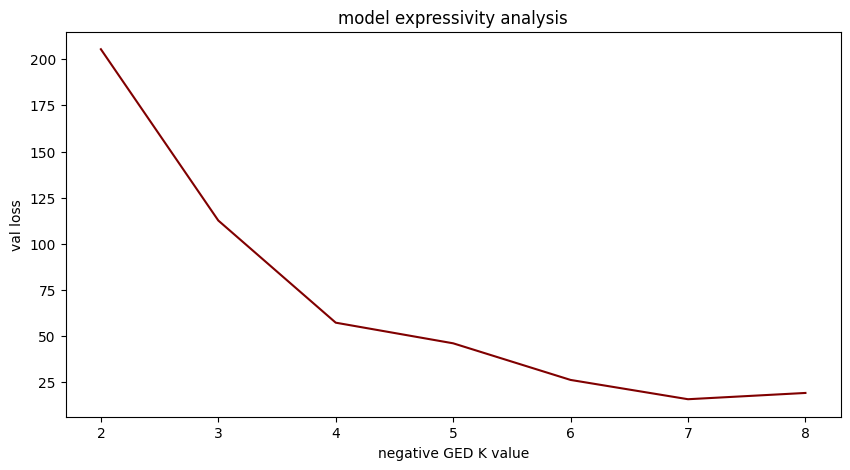

In [76]:
GED_experiments_map = {}
for positive_GED_k, negative_GED_k_to_val_loss_map in positive_GED_k_to_negative_GED_k_to_val_loss_map.items():
    for negative_GED_k, val_loss in negative_GED_k_to_val_loss_map.items():
        GED_experiments_map[f"{positive_GED_k}_{negative_GED_k}"] = val_loss

chart_bar_plot(GED_experiments_map, "positive-GED-K_negative-GED-K", "validation loss", "model expressivity analysis")